# Run CFE Simulation in the Cloud

**Authors**

- Tony Castronova: acastronova@cuahsi.org
- Irene Garousi-Nejad: igarousi@cuahsi.org
- Scott Black: sblack@cuahsi.org

**Last Updated:** 05.17.2023

**Description**


**Data Availability**

This notebook requires the NextGen Hydrofabric that is hosted on http://lynker-spatial.com. These data are subdivided into a series of GeoPackage files grouped relative to the portion of the USA in which they are located.. Data can be accessed in a variety of ways, the simplest being a direct download:

```
wget https://lynker-spatial.s3-us-west-2.amazonaws.com/hydrofabric/v20.1/gpkg/nextgen_16.gpkg
```


**Software Requirements**

- git+https://github.com/CUAHSI/argo-workflow-python-client.git
- geopandas-0.14.4
- fiona-1.9.6
- numpy-1.26.4
- pandas-2.2.2
- pyproj-3.6.1
- shapely-2.0.4
- ipyleaflet-0.19.1
- sidecar-0.7.0
- fsspec-2024.5.0
- s3fs-2024.5.0

In [1]:
from datetime import datetime
import geopandas
from helpers import ArgoAPI, SideCarMap
import fiona
import fsspec

In [5]:
# set argo token, obtained from https://workflows.argo.cuahsi.io/userinfo 
ARGO_TOKEN='Bearer v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.zubzOXsddRlNwSZi5tOxSvZRb7OBbzVJjU-ujswu6bysfY8CajemciGio16osVEd9kUdlY8pE-GMqcWhUlYmC2_pcDwENOqj4gwozXigykwEOSZtVdRng-eHK16alsgO4IrbPtP0wpTMDsdAKwkGM6aNoCf9QxJRkF29v4L8OwYxeXZdo4H3ewZtlLekQ-pmra-SR-ICewBqRmZjPsMFw414vI4gka0pmBmd8lCt2YDME4oHDgmvDXXYsLiS39_qaph-sLYcZFtS4SqTQ6YeXYRBRyRLNZMqLrOY2fyZeRLNswI2iAxVE6109wD9UHczQ8L1Jxa9TIhzyYXAS_Vbyw.0ZQdlfK3xZ6Of7sC.l2hFzI8ZrHQ9Me1oQMnv75idCwf4KS8hCWZuiE4I3X_c9q3QeiQj9n5GnKbZomIVWk_o5fOGuPHj6WEvhM9LEUZ47SJs58Q-A_8cJkqixLICWsCbuQ4RxLjl_0dIOSaU1OGtBF2Qd_KwjXjn-9LbMtwdF62j88WEzypCaGiU82BzYVPfBm3B7_74fwNF_BCVaIGst7tiAx3kIsiw6CqRg4bJo9vO_gZVEimP3zBcEu55MDdtv5X3xSq2guAtO0jxPqu4zhU_Ev58eF-nc8x9I-iHuH7cVVw8OQ.oOF4s8xuQ4I60S22A6tPwQ' 

Create an instance of the `ArgoAPI` class. This will help keep our notebook clean by wrapping Argo REST API function calls.

In [6]:
# create an instance of ArgoAPI using our ARGO_TOKEN
argo = ArgoAPI(ARGO_TOKEN)

List the workflows that are available for us to use.

In [7]:
argo.list_workflows()

['cfe-ngen-configure',
 'cge-configure',
 'collect-aorc-forcing-batch',
 'collect-aorc-forcing-full-v1.1',
 'collect-aorc-forcing-v1',
 'collect-aorc-forcing-v1.1',
 'collect-aorc-forcing-v1.2',
 'huc-to-shp',
 'linked-ngen-metadata',
 'map-reduce-aorc',
 'metadata-extractor',
 'metadata-extractor-path',
 'metadata-extractor-with-dist',
 'mount-example',
 'ngen-run',
 'ngen-v2.0-subset-minio',
 'nwm1-subset-minio',
 'nwm2-subset-minio',
 'omniscient-rhino',
 'parflow-subset-v1-by-huc-minio',
 'run-cfe-complete',
 'run-cfe-complete-new-path',
 's3-data-download',
 'serenity-now',
 'subsetter-dataset-pvc',
 'test-dask',
 'test-entrypoint',
 'test-input-artifacts',
 'test-map-reduce']

We can learn more about these workflows by looking at their metadata.

**TODO: Change to describe workflow, add pretty display**

In [8]:
argo.get_workflow_metadata('run-cfe-complete')

{'api_version': None,
 'kind': None,
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': '2024-01-04T17:28:29Z',
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': 23,
              'labels': {'example': 'true',
                         'workflows.argoproj.io/creator': '112251210534458906530'},
              'managed_fields': [{'api_version': 'argoproj.io/v1alpha1',
                                  'fields_type': 'FieldsV1',
                                  'fields_v1': {'f:metadata': {'f:labels': {'.': {},
                                                                            'f:example': {},
                                                                            'f:workflows.argoproj.io/creator': {}}},
                                                'f:spec': {}},
              

Describe the workflow parameters.

In [9]:
argo.get_workflow_parameters('run-cfe-complete')

[{'default': None,
  'description': None,
  'enum': None,
  'global_name': None,
  'name': 'wb-id',
  'value': 'wb-2851653',
  'value_from': None},
 {'default': None,
  'description': None,
  'enum': None,
  'global_name': None,
  'name': 'vpu-id',
  'value': '16',
  'value_from': None},
 {'default': None,
  'description': None,
  'enum': None,
  'global_name': None,
  'name': 'output-bucket',
  'value': 'subsetter-outputs',
  'value_from': None},
 {'default': None,
  'description': None,
  'enum': None,
  'global_name': None,
  'name': 'start-date',
  'value': '2020-01-01',
  'value_from': None},
 {'default': None,
  'description': None,
  'enum': None,
  'global_name': None,
  'name': 'end-date',
  'value': '2020-01-2',
  'value_from': None}]

To run this workflow, we need to provide values for each of the input parameters listed above. While some of these are obvious others are more nondescript, for example `wb-id` and `vpu-id`. These are attributes obtained from the NextGen Hydrofabric. To simplify the process of acquiring these, we'll use a map interface provided in the `helpers.py` file.

The data that we'll be using this notebook are located inside Vector Processing Unit 16. This area of the Hydrofabric covers the Great Basin. See the [NextGen Hydrofabric](https://mikejohnson51.github.io/hyAggregate/) help pages for more information regarding these data. A geopackage file may consist of many layers. Use `Fiona` to view the vector layers that are included within the `nextgen_16` geopackage.


In [10]:
fiona.listlayers('nextgen_16.gpkg')

['hydrolocations',
 'nexus',
 'flowpaths',
 'lakes',
 'divides',
 'network',
 'flowpath_attributes',
 'layer_styles']

Our workflow will require the ID of the outlet catchment, so let's load the 'divides' layer. This layer contains over 30,000 features so we will not attempt to display it in the notebook. For reference, these data cover the following area:

<div>
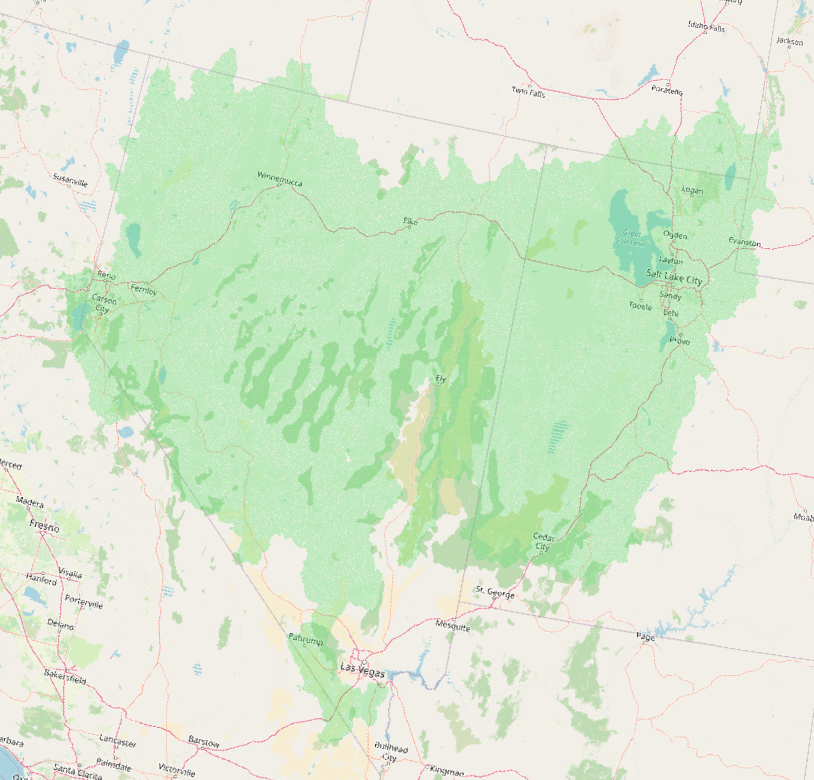
</div>



Load these data into `Geopandas` and convert into the coordinate reference we will be using in out leaflet map (EPSG: 4326).

In [11]:
gdf = geopandas.read_file('nextgen_16.gpkg', layer='divides')
gdf = gdf.to_crs(epsg='4326')

Instantiate the map interface and pass our `divides` geometries so we can query them when the map is clicked.

In [12]:
m = SideCarMap(gdf=gdf)
m.display_map()

After selecting our area of interest on the map, we can access it's metadata in the notebook.

In [107]:
m.selected()

divide_id                                                      cat-2853580
toid                                                           nex-2853581
type                                                               network
ds_id                                                                  NaN
areasqkm                                                         10.710451
id                                                              wb-2853580
lengthkm                                                          3.744205
tot_drainage_areasqkm                                            56.268001
has_flowline                                                          True
geometry                 POLYGON ((-111.7829375267921 40.69318637114995...
Name: 784, dtype: object

We are interested in the `id` attribute of this feature. It should look something like: `wb-2853613`.

Now that we've selected our feature-of-interest, let's prepare the remaining input parameters needed for workflow.

In [22]:
# define input parameters for the job
parameters = {'wd-id': m.selected().id,
              'vpu-id': 16,
              'output-bucket': 'scratch',
              'start-date': '2020-01-01',
              'end-date': '2020-01-10'}

In [23]:
parameters

{'wd-id': 'wb-2853613',
 'vpu-id': 16,
 'output-bucket': 'scratch',
 'start-date': '2020-01-01',
 'end-date': '2020-01-10'}

Submit the workflow!

In [24]:
job_name = argo.submit_workflow('run-cfe-complete-new-path', parameters)
job_name

'run-cfe-complete-new-path-kxhtb'

Get the status of our running job.

In [26]:
import time
while 1:
    progress, phase = argo.get_workflow_status(job_name)
    print(f'{progress} - {phase}')

'Running'

In [81]:
w = argo.workflow_api_instance.workflow_service_get_workflow(argo.namespace, job_name)

def get_node(name):
    job_name = 'run-cfe-complete-new-path-kxhtb'    
    return w.status.nodes[name]
    
def print_status(name, formatting=''):
    node = get_node(name)
    print(f'{formatting}{node.display_name}: {node.phase}')
    children = node.children
    if children is not None:
        formatting += '  '
        for child in children:
            c = get_node(child)
            print_status(child, formatting=formatting)
    

job_name = 'run-cfe-complete-new-path-kxhtb'
#node = argo.workflow_api_instance.workflow_service_get_workflow(argo.namespace, job_name).status.nodes[job_name]
print_status(job_name)

run-cfe-complete-new-path-kxhtb: Succeeded
  run-cfe-complete-new-path-kxhtb(0): Succeeded
    subset-domain: Succeeded
      subset-domain(0): Succeeded
        collect-forcing: Succeeded
          collect-forcing(0): Succeeded
            configure-cfe: Succeeded
              configure-cfe(0): Succeeded
                run-ngen-simulation: Succeeded
                  run-ngen-simulation(0): Succeeded
            run-ngen-simulation: Succeeded
              run-ngen-simulation(0): Succeeded
        configure-cfe: Succeeded
          configure-cfe(0): Succeeded
            run-ngen-simulation: Succeeded
              run-ngen-simulation(0): Succeeded
        run-ngen-simulation: Succeeded
          run-ngen-simulation(0): Succeeded


**TODO: Preview HydroFabric on the Map**

In [93]:
gpk_name = 'wb-2853580_upstream_subset.gpkg'
url=f's3://scratch/tonycastronova/wb-2853580/run-cfe-complete-new-path-4dfwl/domain/{gpk_name}'

In [94]:
import fsspec
s3 = fsspec.filesystem("s3",
                       anon=True,
                       client_kwargs={'endpoint_url':'https://api.minio.cuahsi.io'}
                      )

In [97]:
subset_divides = geopandas.read_file(s3.open(url), layer='divides')
subset_divides = subset_divides.to_crs(epsg='4326')

In [108]:
import ipyleaflet
for idx, row in subset_divides.iterrows():

    wlayer = ipyleaflet.WKTLayer(
        wkt_string=row.geometry.wkt,
            style={'color': 'red', 'opacity':1, 'weight':2.,})
    m.map.add(wlayer)


In [109]:
subset_nexus = geopandas.read_file(s3.open(url), layer='nexus')
subset_nexus = subset_nexus.to_crs(epsg='4326')

for idx, row in subset_nexus.iterrows():

    wlayer = ipyleaflet.WKTLayer(
        wkt_string=row.geometry.wkt,
            style={'color': 'black', 'opacity':1, 'weight':2.,})
    m.map.add(wlayer)


**TODO: Preview Simulation Results**

**TODO: get job logs in real-time**

In [18]:
# workflow_api_instance = argo.workflow_api_instance


# workflow_api_instance.workflow_service_workflow_logs(namespace='workflows',
#                                                      name='run-cfe-complete-new-path-xbz4l',
#                                                      #pod_name='run-cfe-complete-new-path-xbz4l-execute-ngen-simulation-411647',
#                                                      #log_options_container='main',
#                                                      #log_options_insecure_skip_tls_verify_backend=True,
#                                                      )
